In [322]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np

In [286]:
df = pd.read_csv('FinancialMarketData-cleaned.csv')
print(df.head())

   Y       Data  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
0  0  1/11/2000    283.25     0.077  1388.0  157.26  100.56  105.86  1.646   
1  0  1/18/2000    287.65     0.043  1405.0  165.01  101.86  105.47  1.638   
2  0  1/25/2000    287.15     0.135  1368.0  167.24  102.41  106.04  1.650   
3  0   2/1/2000    282.75     0.191  1311.0  166.85  104.92  107.85  1.611   
4  1   2/8/2000    298.40     0.312  1277.0  165.43  104.22  109.30  1.611   

     Cl1  ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  25.77  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  28.85  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  28.28  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  28.22  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  28.02  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1111 non-null   int64  
 1   Data       1111 non-null   object 
 2   XAU BGNL   1111 non-null   float64
 3   ECSURPUS   1111 non-null   float64
 4   BDIY       1111 non-null   float64
 5   CRY        1111 non-null   float64
 6   DXY        1111 non-null   float64
 7   JPY        1111 non-null   float64
 8   GBP        1111 non-null   float64
 9   Cl1        1111 non-null   float64
 10  VIX        1111 non-null   float64
 11  USGG30YR   1111 non-null   float64
 12  GT10       1111 non-null   float64
 13  USGG2YR    1111 non-null   float64
 14  USGG3M     1111 non-null   float64
 15  US0001M    1111 non-null   float64
 16  GTDEM30Y   1111 non-null   float64
 17  GTDEM10Y   1111 non-null   float64
 18  GTDEM2Y    1111 non-null   float64
 19  EONIA      1111 non-null   float64
 20  GTITL30Y

In [288]:
#create columns of mavg(moving averages) for each category
df['VIXmavg'] = df['VIX'].rolling(window=3).mean()
df['JPYmavg'] = df['JPY'].rolling(window=3).mean()
df['USSG2YRmavg'] = df['USGG2YR'].rolling(window=3).mean()
df['MXUSmavg'] = df['MXUS'].rolling(window=3).mean()
df['XAUmavg'] = df['XAU BGNL'].rolling(window=3).mean()
df

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,MXJP,MXBR,MXRU,MXIN,MXCN,VIXmavg,JPYmavg,USSG2YRmavg,MXUSmavg,XAUmavg
0,0,1/11/2000,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,...,990.59,856.76,224.33,217.34,34.30,NaN,NaN,NaN,NaN,NaN
1,0,1/18/2000,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,...,993.98,925.22,234.37,227.08,32.74,NaN,NaN,NaN,NaN,NaN
2,0,1/25/2000,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,...,974.83,886.93,216.82,233.00,32.46,22.340000,105.790000,6.441667,1410.280000,286.016667
3,0,2/1/2000,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,...,1007.12,842.60,201.89,237.48,31.29,22.656667,106.453333,6.490333,1400.010000,285.850000
4,1,2/8/2000,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,...,1034.58,945.15,218.00,258.02,31.32,22.573333,107.730000,6.561333,1394.396667,289.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,3/23/2021,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,...,1199.57,1671.73,681.21,1695.96,110.83,21.373333,108.753333,0.151633,3806.983333,1724.613333
1107,0,3/30/2021,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,...,1206.29,1635.57,693.38,1690.76,108.80,19.900000,109.340000,0.146900,3830.576667,1714.233333
1108,0,4/6/2021,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,...,1194.62,1689.62,673.20,1689.48,111.92,19.343333,109.630000,0.149433,3863.963333,1718.933333
1109,0,4/13/2021,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,...,1197.06,1680.82,680.23,1672.46,108.40,18.126667,109.786667,0.154000,3939.390000,1723.843333


In [289]:
#clean dataset
df = df.dropna()
df

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,MXJP,MXBR,MXRU,MXIN,MXCN,VIXmavg,JPYmavg,USSG2YRmavg,MXUSmavg,XAUmavg
2,0,1/25/2000,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,...,974.83,886.93,216.82,233.00,32.46,22.340000,105.790000,6.441667,1410.280000,286.016667
3,0,2/1/2000,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,...,1007.12,842.60,201.89,237.48,31.29,22.656667,106.453333,6.490333,1400.010000,285.850000
4,1,2/8/2000,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,...,1034.58,945.15,218.00,258.02,31.32,22.573333,107.730000,6.561333,1394.396667,289.433333
5,1,2/15/2000,303.90,0.391,1393.0,169.5800,104.690,108.73,1.5970,30.06,...,1007.86,885.56,204.59,288.98,27.66,22.540000,108.626667,6.626667,1388.910000,295.016667
6,1,2/22/2000,305.50,0.497,1481.0,168.8600,103.280,110.92,1.6170,29.62,...,987.38,866.46,206.14,315.21,27.95,23.343333,109.650000,6.619000,1365.783333,302.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,3/23/2021,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,...,1199.57,1671.73,681.21,1695.96,110.83,21.373333,108.753333,0.151633,3806.983333,1724.613333
1107,0,3/30/2021,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,...,1206.29,1635.57,693.38,1690.76,108.80,19.900000,109.340000,0.146900,3830.576667,1714.233333
1108,0,4/6/2021,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,...,1194.62,1689.62,673.20,1689.48,111.92,19.343333,109.630000,0.149433,3863.963333,1718.933333
1109,0,4/13/2021,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,...,1197.06,1680.82,680.23,1672.46,108.40,18.126667,109.786667,0.154000,3939.390000,1723.843333


In [290]:
#find correlation matrix (1: positive correlation, -1: negative correlation, 0: no correlation)
df_new = df[df.columns[-5:]]
corr= df_new.corr(method = 'pearson')
corr

,VIXmavg,JPYmavg,USSG2YRmavg,MXUSmavg,XAUmavg
VIXmavg,1.000000,-0.135693,-0.106125,-0.239759,-0.077031
JPYmavg,-0.135693,1.000000,0.499287,0.115906,-0.578729
USSG2YRmavg,-0.106125,0.499287,1.000000,-0.259057,-0.743015
MXUSmavg,-0.239759,0.115906,-0.259057,1.000000,0.625948
XAUmavg,-0.077031,-0.578729,-0.743015,0.625948,1.000000


In [291]:
target = df['Y']
df = df[df.columns[-5:]]
inputs = df = df[df.columns[-5:]]
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [292]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

In [293]:
#XGB Boost
xgb_model = xgb.XGBClassifier(random_state=37)
evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
df['XGB_prediction'] = xgb_model.predict(inputs)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       172
           1       0.84      0.72      0.77        50

    accuracy                           0.91       222
   macro avg       0.88      0.84      0.86       222
weighted avg       0.90      0.91      0.90       222



In [294]:
#Logistic Regression
lr_model = LogisticRegression(random_state=37)
evaluate_model(lr_model, X_train, X_test, y_train, y_test)
df['LR_prediction'] = lr_model.predict(df[X_train.columns])


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91       172
           1       0.75      0.48      0.59        50

    accuracy                           0.85       222
   macro avg       0.81      0.72      0.75       222
weighted avg       0.84      0.85      0.83       222



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [295]:
#build isolation forest model
inputs = ['VIXmavg', 'JPYmavg']

In [296]:
model_IF = IsolationForest(random_state=37) #outlier
model_IF.fit(df[inputs]) #train the model

IsolationForest(random_state=37)

In [297]:
#create 2 new columns
df['anomaly_scores'] = model_IF.decision_function(df[inputs]) #lower score, more abnormal
df['anomaly'] = model_IF.predict(df[inputs])

In [298]:
#slicing
df.loc[:,['VIXmavg','JPYmavg','anomaly_scores','anomaly']] #-1 if anomaly is present

,VIXmavg,JPYmavg,anomaly_scores,anomaly
2,22.340000,105.790000,0.082138,1
3,22.656667,106.453333,0.091517,1
4,22.573333,107.730000,0.087900,1
5,22.540000,108.626667,0.084859,1
6,23.343333,109.650000,0.074889,1
...,...,...,...,...
1106,21.373333,108.753333,0.090378,1
1107,19.900000,109.340000,0.086981,1
1108,19.343333,109.630000,0.080577,1
1109,18.126667,109.786667,0.084953,1


In [299]:
def outlier_plot(data,outlier_method_name, x_var, y_var, xaxis_limits=[0,1], yaxis_limits=[0,1]):
  method = f"{outlier_method_name}_anomaly"

  print(f"Number of anomalies {len(data[data['anomaly']==-1])}")
  print(f"Number of non-anomalies {len(data[data['anomaly']==1])}")
  print(f"Total Number of Values: {len(data)}")

  g = sns.FacetGrid(data, col="anomaly", height=4, hue="anomaly", hue_order=[1,-1])
  g.map(sns.scatterplot, x_var, y_var)
  g.fig.suptitle(f'Outlier Model: {outlier_method_name}', y=1.05)
  g.set(xlim=xaxis_limits, ylim=yaxis_limits)

  axes=g.axes.flatten()
  axes[0].set_title(f'Outliers {len(data[data["anomaly"]==-1])}')
  axes[1].set_title(f'Non-Outliers {len(data[data["anomaly"]==1])}')

  return g

Number of anomalies 296
Number of non-anomalies 813
Total Number of Values: 1109


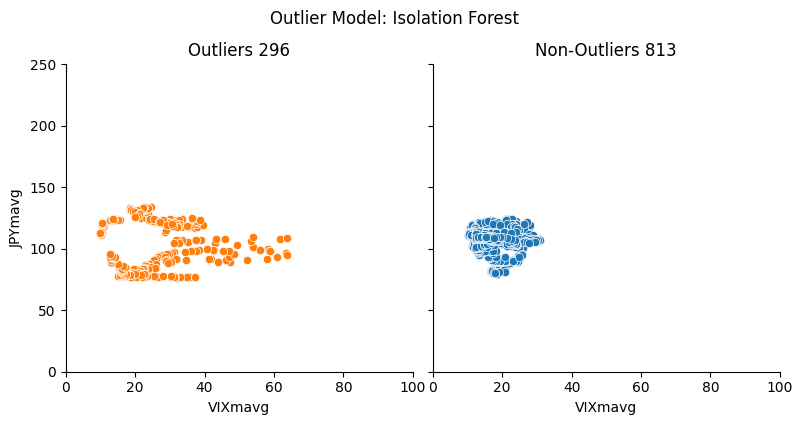

In [300]:
outlier_plot(df, "Isolation Forest",'VIXmavg', 'JPYmavg',[0,100],[0,250]);

In [301]:
#more parameters
inputs = ['VIXmavg', 'JPYmavg', 'USSG2YRmavg','MXUSmavg','XAUmavg']

In [302]:
model_IF = IsolationForest(random_state=37) #outlier
model_IF.fit(df[inputs])

IsolationForest(random_state=37)

In [303]:
df['anomaly_scores'] = model_IF.decision_function(df[inputs]) #lower score, more abnormal
df['anomaly'] = model_IF.predict(df[inputs])

Number of anomalies 273
Number of non-anomalies 836
Total Number of Values: 1109


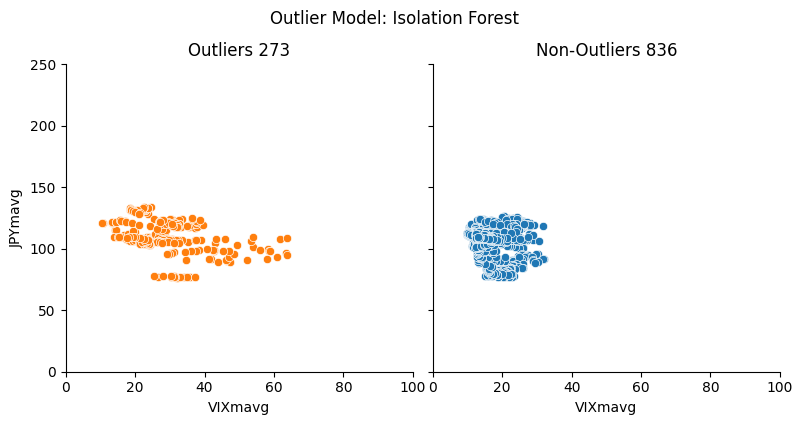

In [304]:
outlier_plot(df, "Isolation Forest",'VIXmavg', 'JPYmavg',[0,100],[0,250])

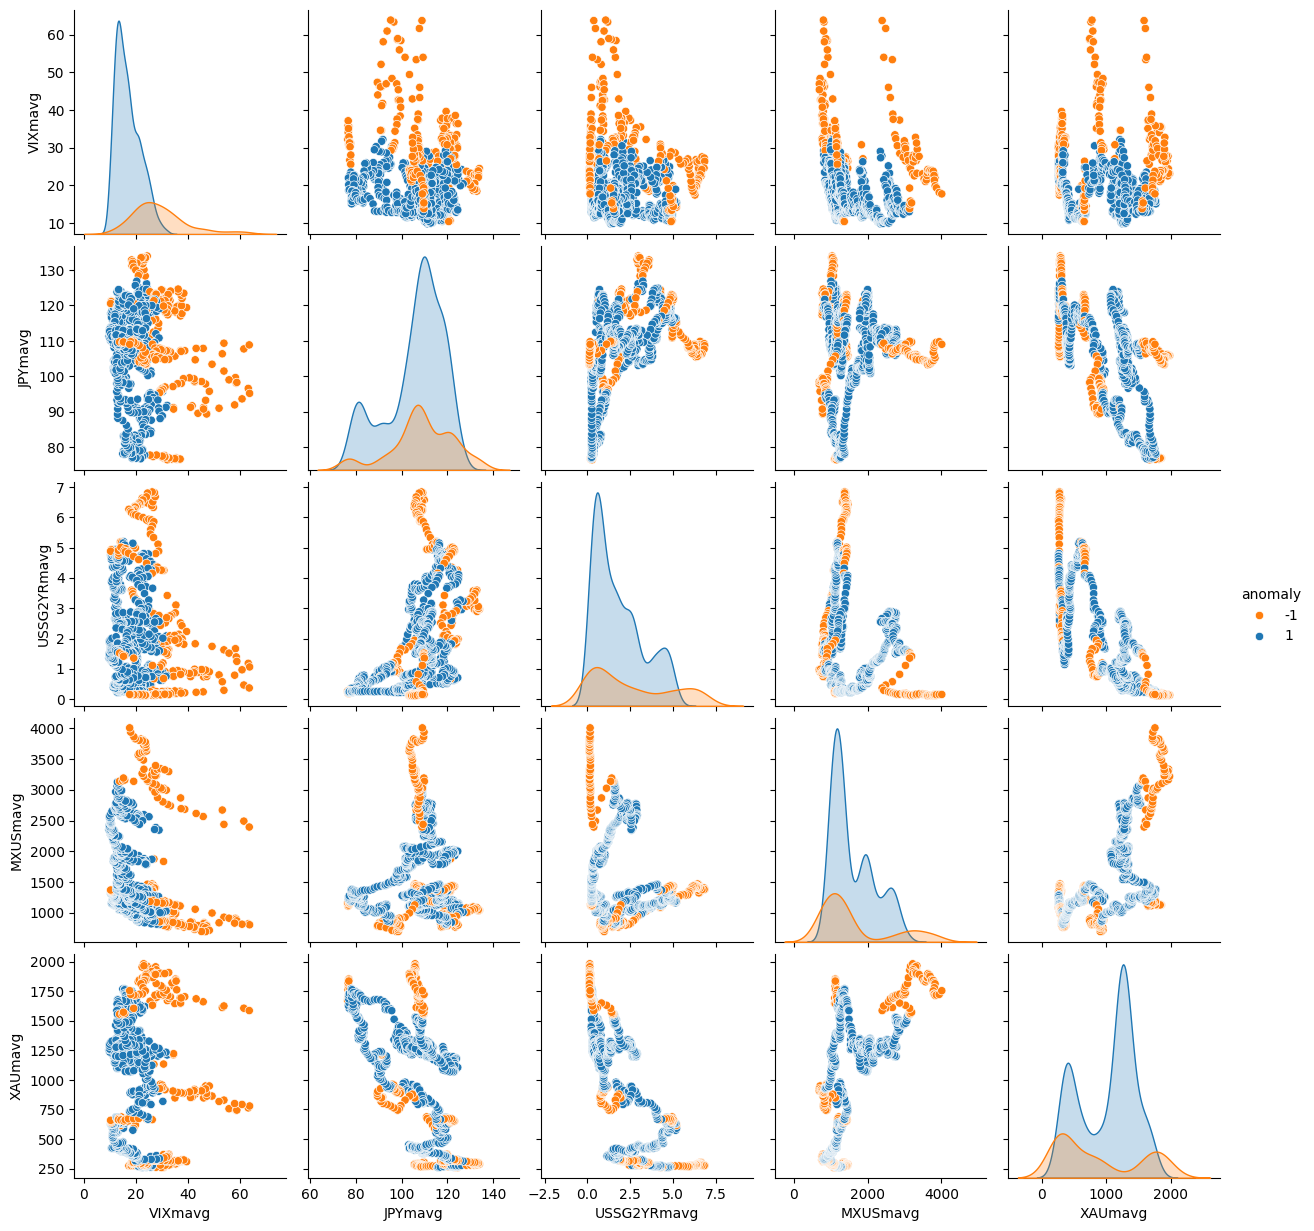

In [305]:
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df, vars=inputs, hue='anomaly', palette=palette)
#shows the distribution of the orange

In [323]:
df['profit_loss'] = np.random.uniform(-1, 1, size=len(df))

def decision(anomaly, lr_pred, xgb_pred):
    if anomaly == -1:
        return "Sell stocks; Do not invest"
    elif lr_pred == 1 and xgb_pred == 1:
        return "Buy stocks; Invest"
    else:
        return "Sell stocks; Do not invest"

df['investment_decision'] = df.apply(
    lambda row: decision(row['anomaly'], row['LR_prediction'], row['XGB_prediction']), axis=1)
df['profit_with_strategy'] = df.apply(
    lambda row: row['profit_loss'] if row['investment_decision'] == "Buy stocks; Invest" else 0, axis=1
)

In [324]:
if 'profit_loss' in df.columns:
    df['profit_with_strategy'] = df.apply(
        lambda row: row['profit_loss'] if row['investment_decision'] == "Invest" else 0, axis=1
    )
    total_profit_with_strategy = df['profit_with_strategy'].sum()
    print(f"Total Profit with Strategy: {total_profit_with_strategy}")

    # Verify
    print(df[['profit_loss', 'investment_decision', 'profit_with_strategy']].head(20))
    total_profit_without_strategy = df['profit_loss'].sum()
    print(f"Total Profit without Strategy: {total_profit_without_strategy}")

Total Profit with Strategy: 0
    profit_loss         investment_decision  profit_with_strategy
2     -0.315662  Sell stocks; Do not invest                     0
3     -0.227182  Sell stocks; Do not invest                     0
4      0.947556  Sell stocks; Do not invest                     0
5     -0.341343  Sell stocks; Do not invest                     0
6     -0.317077  Sell stocks; Do not invest                     0
7     -0.404661  Sell stocks; Do not invest                     0
8     -0.486611  Sell stocks; Do not invest                     0
9     -0.208449  Sell stocks; Do not invest                     0
10     0.338654  Sell stocks; Do not invest                     0
11    -0.234727  Sell stocks; Do not invest                     0
12     0.078062  Sell stocks; Do not invest                     0
13    -0.051225  Sell stocks; Do not invest                     0
14    -0.651724  Sell stocks; Do not invest                     0
15     0.894597  Sell stocks; Do not invest   